# 🧠 Weather Type Classification — Notebook 2: Modeling & Selection

### **🎯 Mục tiêu chính của Notebook này:**

1.  **Tìm kiếm và Lựa chọn Siêu tham số Tối ưu:**
    *   Với mỗi thuật toán (Logistic Regression, SVM, XGBoost), chúng ta sẽ thử nghiệm nhiều cấu hình siêu tham số khác nhau.
    *   Mô hình sẽ được huấn luyện trên tập **`train`** và đánh giá trên tập **`validation`** để tìm ra cấu hình cho kết quả tốt nhất.
    *   Chỉ số chính để lựa chọn là **Macro F1-Score**, một độ đo phù hợp cho bài toán phân loại đa lớp.

2.  **Huấn luyện lại (Refit) Mô hình Tốt nhất:**
    *   Sau khi đã chọn được cấu hình tối ưu cho mỗi mô hình, chúng ta sẽ huấn luyện lại chúng trên một tập dữ liệu lớn hơn (gộp cả **`train`** và **`validation`**) để tận dụng tối đa dữ liệu học.

3.  **Đánh giá Cuối cùng trên Tập Test:**
    *   Các mô hình đã được huấn luyện lại sẽ được đánh giá lần cuối trên tập **`test`** – một tập dữ liệu hoàn toàn "mới" mà mô hình chưa từng thấy.
    *   Kết quả trên tập test sẽ là thước đo cuối cùng để so sánh hiệu suất và chọn ra mô hình chiến thắng.

### **🗺️ Quy trình thực hiện:**

1.  **Thiết lập Môi trường:** Nhập thư viện, định nghĩa các đường dẫn và hằng số, và quan trọng nhất là **tải các "artifact" (dữ liệu đã chia, preprocessor) từ notebook trước**.
2.  **Xây dựng và Kiểm tra Preprocessor:** Đảm bảo rằng pipeline tiền xử lý hoạt động đúng như mong đợi.
3.  **Định nghĩa Thí nghiệm:** Thiết lập các mô hình cơ sở và lưới siêu tham số (`GRIDS`) để thử nghiệm.
4.  **Chạy Đánh giá trên Validation:** Tự động hóa quá trình huấn luyện và đánh giá từng cấu hình.
5.  **Lựa chọn và Huấn luyện lại:** Chọn ra các cấu hình tốt nhất và huấn luyện lại trên dữ liệu gộp.
6.  **Đánh giá trên Test:** Thực hiện đánh giá cuối cùng và lưu lại tất cả các kết quả, biểu đồ.

---

# 📑 Mục lục

1. [Thiết lập Môi trường](#1-thiet-lap-moi-truong)
2. [Tải dữ liệu](#12-tai-du-lieu)
3. [Xây dựng và Kiểm tra Preprocessor](#2-xay-dung-va-kiem-tra-preprocessor)
4. [Định nghĩa Mô hình & Lưới Siêu tham số](#3-dinh-nghia-cac-mo-hinh--luoi-sieu-tham-so)
5. [Đánh giá trên Tập Validation](#4-danh-gia-cac-cau-hinh-tren-tap-validation)
6. [Chọn cấu hình tốt nhất](#5-lua-chon-cau-hinh-tot-nhat-cho-tung-mo-hinh)
7. [Huấn luyện lại mô hình](#6-huan-luyen-lai-refit-mo-hinh-tot-nhat)
8. [Đánh giá trên Test](#7-danh-gia-cuoi-cung-tren-tap-test)
9. [Tổng hợp kết quả](#9-tong-hop-ket-qua-cho-bao-cao-report-generation)


---

## 1. ⚙️ Thiết lập Môi trường

**Mục tiêu:** Chuẩn bị không gian làm việc, tải các thư viện cần thiết và các tài nguyên đã được xử lý từ bước trước để đảm bảo tính nhất quán và khả năng tái lập.

**Giải thích:** Thay vì lặp lại các bước tiền xử lý từ đầu, chúng ta sẽ tận dụng các kết quả đã được lưu lại từ notebook EDA. Việc này không chỉ tiết kiệm thời gian mà còn đảm bảo rằng các mô hình được huấn luyện và đánh giá trên cùng một cấu trúc dữ liệu đã được chuẩn hóa.

### 1.1. Nhập các thư viện cần thiết

In [1]:

# Util
import os
import sys
import random
import joblib

# Xử lý dữ liệu & Đại số tuyến tính
import numpy as np

# Học máy
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


In [2]:
sys.path.append(os.path.abspath(".."))

from src.preprocess import *
from src.utils import *

SEED = 42
random.seed(SEED); np.random.seed(SEED)

BASE_DIR = resolve_root()
DATA_PATH = BASE_DIR / 'data' / 'raw' / 'weather_classification_data.csv'
OUT_TBL = BASE_DIR / 'reports' / 'tables'
OUT_FIG = BASE_DIR / 'Images' / 'reports' / 'figures'
OUT_MDL = BASE_DIR / 'models'
ARTIFACTS = Path("../artifacts")
REPORTS = Path("../reports/tables")

for p in [OUT_TBL, OUT_FIG, OUT_MDL]:
    p.mkdir(parents=True, exist_ok=True)
    
print('Resolved ROOT:', BASE_DIR)

d:\ML\Weather-type-prediction-on-tabular-dataset\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resolved ROOT: D:\ML\Weather-type-prediction-on-tabular-dataset


### 1.2. Tải dữ liệu

Ở bước này, chúng ta sẽ tải các "artifact" đã được tạo ra và lưu lại từ notebook `1_preprocessing_eda.ipynb`. Các artifact này bao gồm:

-   **Dữ liệu đã chia (Splits):** `X_train`, `X_val`, `X_test` và các nhãn `y` tương ứng. Đây là dữ liệu **thô**, chưa qua biến đổi.
-   **Preprocessor:** Một đối tượng `ColumnTransformer` đã được `fit` trên tập `X_train`. Nó chứa toàn bộ logic để chuẩn hóa và mã hóa dữ liệu.
-   **Thông tin đặc trưng (Metadata):** File JSON chứa danh sách các cột số, phân loại và log-transform.

Việc này đảm bảo rằng chúng ta không bị "rò rỉ dữ liệu" (data leakage) từ tập validation/test vào quá trình `fit` của preprocessor.

#### 1.2.1 Tải dữ liệu train/val/test

In [3]:
# Dữ liệu gốc (chưa xử lý)
X_train = joblib.load(ARTIFACTS / "X_train_proc.pkl")
X_val = joblib.load(ARTIFACTS / "X_val_proc.pkl")
X_test = joblib.load(ARTIFACTS / "X_test_proc.pkl")

y_train = joblib.load(ARTIFACTS / "y_train.pkl")
y_val = joblib.load(ARTIFACTS / "y_val.pkl")
y_test = joblib.load(ARTIFACTS / "y_test.pkl")

preprocessor = joblib.load(ARTIFACTS / "preprocessor.pkl")

with open(ARTIFACTS / "preprocessor.pkl", "rb") as f:
    preprocessor = joblib.load(f)

print("✅ Preprocessor loaded!")

✅ Preprocessor loaded!


#### 1.2.2 Tải thông tin đặc trưng

In [4]:
with open(REPORTS / "feature_lists.json", "r", encoding="utf-8") as f:
    meta = json.load(f)

label_col = meta["label_col"]
cat_features = meta["categorical"]
num_features = meta["numeric"]
log1p_features = meta["log1p"]

print("✅ Metadata loaded!")
print(json.dumps(meta, indent=2, ensure_ascii=False))

✅ Metadata loaded!
{
  "label_col": "Weather Type",
  "categorical": [
    "Cloud Cover",
    "Season",
    "Location"
  ],
  "numeric": [
    "Atmospheric Pressure",
    "Humidity",
    "Precipitation (%)",
    "Temperature",
    "UV Index"
  ],
  "log1p": [
    "Wind Speed",
    "Visibility (km)"
  ]
}


## 2️⃣ Xây dựng và Kiểm tra Preprocessor

**Mục tiêu:** Xác minh rằng `preprocessor` đã tải lên hoạt động chính xác bằng cách biến đổi một vài mẫu dữ liệu và quan sát kết quả.

Đây là một bước kiểm tra nhanh (sanity check) để đảm bảo pipeline tiền xử lý đang áp dụng đúng các phép biến đổi (chuẩn hóa, log-transform, one-hot encoding) cho các cột tương ứng. Chúng ta sẽ xem dữ liệu trông như thế nào "trước" và "sau" khi đi qua `preprocessor`.

In [5]:
df_train = pd.read_csv(DATA_PATH)  # hoặc DataFrame gốc trước khi pre-processing
X_train_df = df_train.drop(columns=[label_col])
sample = X_train_df.sample(3, random_state=42)

print("Before transform:")
display(sample)

print("After transform:")
display(pd.DataFrame(preprocessor.fit_transform(sample)))


Before transform:


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
4111,23.0,38,4.5,6.0,clear,1021.19,9,Autumn,10.0,inland
10607,62.0,94,14.5,83.0,clear,1025.57,10,Summer,4.0,inland
7372,40.0,51,2.0,12.0,partly cloudy,1025.15,8,Spring,8.0,mountain


After transform:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.408864,-0.961118,-0.791158,-1.169207,0.000000,-0.211368,0.985475,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.810857,1.378996,1.410740,1.273600,1.224745,1.316672,-1.371162,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.598007,-0.417878,-0.619582,-0.104393,-1.224745,-1.105304,0.385686,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## 3️⃣ Định nghĩa các Mô hình & Lưới Siêu tham số

**Mục tiêu:** Chuẩn bị các "ứng cử viên" mô hình và các không gian siêu tham số tương ứng để tiến hành tìm kiếm cấu hình tốt nhất.

**Giải thích:**
-   **`MODELS`**: Một dictionary chứa các instance của các mô hình cơ sở mà chúng ta muốn thử nghiệm. Mỗi mô hình được khởi tạo với các tham số mặc định và `random_state=SEED` để đảm bảo kết quả nhất quán.
    -   **Logistic Regression**: Một mô hình tuyến tính mạnh mẽ và nhanh, thường được dùng làm baseline.
    -   **SVM (Support Vector Machine)**: Hiệu quả với không gian nhiều chiều và có thể xử lý các mối quan hệ phi tuyến tính thông qua kernel RBF.
    -   **XGBoost**: Một thuật toán Gradient Boosting mạnh mẽ, thường cho hiệu suất hàng đầu trong các bài toán dữ liệu có cấu trúc.
-   **`GRIDS`**: Một dictionary chứa danh sách các cấu hình siêu tham số cần thử cho mỗi mô hình. Mỗi cấu hình bao gồm một `config_id` để dễ nhận diện và một dictionary `params` chứa các giá trị siêu tham số cụ thể.

In [6]:
MODELS = {
    "logreg": LogisticRegression(
        penalty="l2", solver="lbfgs", multi_class="multinomial",
        max_iter=200, random_state=SEED
    ),
    "svm": SVC(
        kernel="rbf", probability=True, random_state=SEED
    ),
    "xgb": XGBClassifier(
        objective="multi:softprob",
        num_class=len(np.unique(y_train)),
        random_state=SEED, n_jobs=1, 
        tree_method="hist", 
        eval_metric="mlogloss"
    ),
}

# Lưới tham số cần thử
GRIDS = {
    "logreg": [
        {"config_id": f"C{v}", "params": {"C": v}} 
        for v in [0.3, 1.0, 3.0, 10.0, 30.0]
    ],
    "svm": [
        {"config_id": "C0.3_gscale", "params": {"C": 0.3, "gamma": "scale"}},
        {"config_id": "C1_gscale",   "params": {"C": 1.0, "gamma": "scale"}},
        {"config_id": "C3_gauto",    "params": {"C": 3.0, "gamma": "auto"}},
        {"config_id": "C3_gscale",   "params": {"C": 3.0, "gamma": "scale"}},
        {"config_id": "C10_gscale",  "params": {"C": 10.0, "gamma": "scale"}},
    ],
    "xgb": [
        {"config_id": "A", "params": {"n_estimators": 200, "max_depth": 3, "learning_rate": 0.1, "subsample": 1.0, "colsample_bytree": 1.0}},
        {"config_id": "B", "params": {"n_estimators": 300, "max_depth": 5, "learning_rate": 0.1, "subsample": 1.0, "colsample_bytree": 1.0}},
        {"config_id": "C", "params": {"n_estimators": 500, "max_depth": 4, "learning_rate": 0.05,"subsample": 0.8, "colsample_bytree": 1.0}},
        {"config_id": "D", "params": {"n_estimators": 200, "max_depth": 6, "learning_rate": 0.05,"subsample": 0.8, "colsample_bytree": 0.8}},
        {"config_id": "E", "params": {"n_estimators": 400, "max_depth": 3, "learning_rate": 0.03,"subsample": 1.0, "colsample_bytree": 0.8}},
    ],
}

## 4️⃣ Đánh giá các Cấu hình trên Tập Validation

**Mục tiêu:** Tự động hóa việc huấn luyện từng mô hình với mỗi cấu hình siêu tham số trong `GRIDS` và đánh giá hiệu suất của chúng trên tập `validation`.

**Giải thích:**
Đây là bước cốt lõi của việc lựa chọn mô hình. Thay vì đoán mò, chúng ta sẽ thử nghiệm một cách có hệ thống.
-   Hàm `eval_on_val` (từ `src/utils.py`) sẽ được sử dụng để lặp qua từng cấu hình.
-   Với mỗi cấu hình, một `Pipeline` hoàn chỉnh bao gồm `preprocessor` và mô hình sẽ được tạo ra.
-   Pipeline này sẽ được huấn luyện trên tập `X_train`, `y_train` và sau đó đưa ra dự đoán trên `X_val`.
-   **Macro F1-score** và **Accuracy** trên tập `validation` sẽ được ghi lại. Chúng ta dùng tập validation để "tinh chỉnh" mô hình, tránh việc làm rò rỉ thông tin từ tập test.

**Kết quả mong đợi:** Một file CSV (`val_grid_results.csv`) và một DataFrame chứa kết quả đánh giá của tất cả các thử nghiệm, giúp chúng ta dễ dàng so sánh.


In [7]:
frames = [eval_on_val(mk, est, GRIDS[mk],
                      preprocessor,
                      X_train, y_train,
                      X_val, y_val)
          for mk, est in MODELS.items()]
val_grid = pd.concat(frames, ignore_index=True)

val_grid_path = OUT_TBL / "val_grid_results.csv"
val_grid.to_csv(val_grid_path, index=False)
print("✅ Saved:", val_grid_path)

display(
    val_grid.sort_values(["model","macro_f1_val"], ascending=[True, False])
            .groupby("model")
            .head(5)
)

d:\ML\Weather-type-prediction-on-tabular-dataset\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\ML\Weather-type-prediction-on-tabular-dataset\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\ML\Weather-type-prediction-on-tabular-dataset\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\ML\Weather-type-prediction-on-tabular-dataset\

✅ Saved: D:\ML\Weather-type-prediction-on-tabular-dataset\reports\tables\val_grid_results.csv


,model,config_id,params_json,macro_f1_val,accuracy_val
1,logreg,C1.0,"{""C"": 1.0}",0.870600,0.870455
2,logreg,C3.0,"{""C"": 3.0}",0.870600,0.870455
3,logreg,C10.0,"{""C"": 10.0}",0.869818,0.869697
4,logreg,C30.0,"{""C"": 30.0}",0.869818,0.869697
0,logreg,C0.3,"{""C"": 0.3}",0.868267,0.868182
9,svm,C10_gscale,"{""C"": 10.0, ""gamma"": ""scale""}",0.907752,0.907576
5,svm,C0.3_gscale,"{""C"": 0.3, ""gamma"": ""scale""}",0.905384,0.904545
7,svm,C3_gauto,"{""C"": 3.0, ""gamma"": ""auto""}",0.904836,0.904545
6,svm,C1_gscale,"{""C"": 1.0, ""gamma"": ""scale""}",0.903493,0.903030
8,svm,C3_gscale,"{""C"": 3.0, ""gamma"": ""scale""}",0.903258,0.903030


## 5️⃣ Lựa chọn Cấu hình Tốt nhất cho Từng Mô hình

**Mục tiêu:** Từ kết quả trên tập validation, chọn ra một cấu hình siêu tham số tốt nhất cho mỗi loại mô hình.

**Giải thích:**
Dựa trên DataFrame `val_grid`, chúng ta sẽ nhóm kết quả theo `model`, sau đó sắp xếp theo `macro_f1_val` (và `accuracy` làm tiêu chí phụ) để tìm ra dòng có hiệu suất cao nhất. Kết quả này sẽ được lưu lại để sử dụng trong bước tiếp theo.

In [8]:
best = (
    val_grid.sort_values(["macro_f1_val","accuracy_val"], ascending=False)
             .groupby("model", as_index=False)
             .head(1)
)
best.to_csv(OUT_TBL / "best_val_by_model.csv", index=False)
print("✅ Saved best config per model:")
display(best)


✅ Saved best config per model:


,model,config_id,params_json,macro_f1_val,accuracy_val
12,xgb,C,"{""n_estimators"": 500, ""max_depth"": 4, ""learnin...",0.916141,0.915909
9,svm,C10_gscale,"{""C"": 10.0, ""gamma"": ""scale""}",0.907752,0.907576
1,logreg,C1.0,"{""C"": 1.0}",0.870600,0.870455



## 6️⃣ Huấn luyện lại (Refit) Mô hình Tốt nhất trên Dữ liệu Gộp

**Mục tiêu:** Tận dụng tối đa dữ liệu có sẵn bằng cách huấn luyện các mô hình có cấu hình tốt nhất trên cả tập `train` và `val` gộp lại.

**Giải thích:**
Sau khi đã sử dụng tập validation để chọn siêu tham số, vai trò của nó đã hoàn thành. Để mô hình học được nhiều thông tin nhất có thể trước khi đối mặt với tập test, chúng ta sẽ gộp dữ liệu huấn luyện và validation lại.
-   Code sẽ lặp qua DataFrame `best` đã tạo ở bước trước.
-   Với mỗi mô hình, một pipeline mới sẽ được tạo, thiết lập các tham số tốt nhất, và được `fit` trên `X_tr_all` và `y_tr_all_enc`.
-   Các pipeline đã được huấn luyện hoàn chỉnh này sẽ được lưu vào thư mục `models/` dưới dạng file `.joblib` để có thể tái sử dụng mà không cần huấn luyện lại.

In [9]:
# Nối train + val
X_tr_all = pd.concat([X_train, X_val], axis=0)

# Encode nhãn
le = LabelEncoder()
y_tr_all_enc = le.fit_transform(np.concatenate([y_train, y_val]))

fitted = {}
for _, r in best.iterrows():
    mk = r["model"]
    params = json.loads(r["params_json"])
    
    # Khởi tạo estimator mới
    est = MODELS[mk].__class__(**MODELS[mk].get_params())
    
    # Pipeline gồm preprocessor + estimator
    pipe = Pipeline(steps=[("prep", preprocessor), ("clf", est)])
    
    # Set các tham số tốt nhất
    pipe.set_params(**{f"clf__{k}": v for k, v in params.items()})
    
    # Fit trên toàn bộ train+val (encoded labels)
    pipe.fit(X_tr_all, y_tr_all_enc)
    
    # Lưu pipeline đã fit
    fitted[mk] = pipe
    joblib.dump(pipe, OUT_MDL / f"{mk}_best.joblib")
    
    # Lưu thông tin params
    with open(OUT_TBL / f"{mk}_best_params.json", "w") as f:
        json.dump({"model": mk, "config_id": r["config_id"], "params": params}, f, indent=2)

print("✅ Saved all fitted models & best params.")

✅ Saved all fitted models & best params.


d:\ML\Weather-type-prediction-on-tabular-dataset\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## 7️⃣ Đánh giá Cuối cùng trên Tập Test

**Mục tiêu:** Đánh giá hiệu suất thực tế của các mô hình đã được lựa chọn và huấn luyện lại trên tập dữ liệu hoàn toàn mới (tập `test`).

**Giải thích:**
Đây là bước quan trọng nhất để đưa ra kết luận cuối cùng về mô hình nào hoạt động tốt nhất. Tập `test` được giữ riêng cho đến tận bước này để đảm bảo kết quả đánh giá là khách quan và không bị thiên vị.
-   Chúng ta sẽ tải các pipeline đã được `fit` từ thư mục `models/`.
-   Với mỗi pipeline, chúng ta sẽ:
    1.  Dự đoán trên `X_test`.
    2.  Tạo và lưu **báo cáo phân loại** chi tiết (precision, recall, f1-score cho từng lớp).
    3.  Vẽ và lưu **ma trận nhầm lẫn** để trực quan hóa lỗi của mô hình.
    4.  Vẽ và lưu các đường cong **ROC** và **Precision-Recall** (cho các mô hình hỗ trợ `predict_proba`).
    5.  Tổng hợp các chỉ số chính (Accuracy, Macro F1) vào một bảng so sánh cuối cùng.## 8. Test Evaluation

In [10]:
rows = []

le.fit(y_train)  # fit trên y_train thô
y_test_enc = le.transform(y_test)

for mk, pipe in fitted.items():
    # Dự đoán
    y_pred = pipe.predict(X_test)
    
    # Nếu có predict_proba thì lấy probability
    y_proba = pipe.predict_proba(X_test) if hasattr(pipe.named_steps["clf"], "predict_proba") else None

    # Báo cáo classification report
    rep = classification_report(
        y_test_enc, 
        y_pred,
        target_names=list(le.classes_),
        output_dict=True,
        digits=4
    )
    pd.DataFrame(rep).T.to_csv(OUT_TBL / f"{mk}_test_report.csv")
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_test_enc, y_pred, labels=np.arange(len(le.classes_)))
    plot_and_save_confusion(cm, le.classes_, f"Confusion Matrix — {mk.upper()} (Test)", OUT_FIG / f"{mk}_test_confusion.png")
    
    # ROC & PR
    if y_proba is not None:
        roc_pr_ovr(y_test_enc, y_proba, le.classes_, mk, OUT_FIG)
    
    # Tính các metrics cơ bản
    rows.append({
        "model": mk,
        "macro_f1_test": f1_score(y_test_enc, y_pred, average="macro"),
        "accuracy_test": accuracy_score(y_test_enc, y_pred)
    })

# --- Lưu summary test ---
test_summary = pd.DataFrame(rows).sort_values("macro_f1_test", ascending=False)
test_summary.to_csv(OUT_TBL / "test_summary.csv", index=False)

print("✅ Saved all test reports, confusion matrices, ROC/PR plots, and test_summary.csv")
display(test_summary)


✅ Saved all test reports, confusion matrices, ROC/PR plots, and test_summary.csv


,model,macro_f1_test,accuracy_test
0,xgb,0.919921,0.919697
1,svm,0.913052,0.912879
2,logreg,0.874634,0.874242


### **8. Kiểm tra cuối cùng (Sanity Checks)**

**Mục tiêu:** Đảm bảo quy trình không mắc phải các lỗi phổ biến.

In [11]:
print("Sanity checks:")
print(" - No explicit transform on test outside Pipeline.")
print(" - Label order:", list(le.classes_))

Sanity checks:
 - No explicit transform on test outside Pipeline.
 - Label order: ['Cloudy', 'Rainy', 'Snowy', 'Sunny']


### **9. Tổng hợp Kết quả cho Báo cáo (Report Generation)**

In [12]:
# Danh sách các mô hình và tên hiển thị trong báo cáo
model_map = {
    "logreg": "Logistic Regression",
    "svm": "SVM (RBF)",
    "xgb": "XGBoost"
}
target_classes = list(le.classes_)  # ['Cloudy', 'Rainy', 'Snowy', 'Sunny']

# -----------------------------------------------------------------------------
# 9.1. Tái tạo Bảng 5: Tổng quan hiệu năng (đã có ở test_summary.csv)
# -----------------------------------------------------------------------------
print("\n--- Bảng 5: Hiệu năng trên test ---")
df_summary = pd.read_csv(OUT_TBL / "test_summary.csv")
df_summary["model_name"] = df_summary["model"].map(model_map)
df_summary = df_summary[["model_name", "macro_f1_test", "accuracy_test"]]
display(df_summary)


--- Bảng 5: Hiệu năng trên test ---


,model_name,macro_f1_test,accuracy_test
0,XGBoost,0.919921,0.919697
1,SVM (RBF),0.913052,0.912879
2,Logistic Regression,0.874634,0.874242


In [13]:
# -----------------------------------------------------------------------------
# 9.2. Tái tạo Bảng 6: F1-score theo từng nhãn
# -----------------------------------------------------------------------------
f1_by_label = {}

for mk in model_map.keys():
    # Đọc lại file report đã lưu
    report_path = OUT_TBL / f"{mk}_test_report.csv"
    df_rep = pd.read_csv(report_path, index_col=0)
    
    # Lấy cột f1-score cho các class mục tiêu
    # Lưu ý: file csv lưu dạng Transpose nên index là tên class
    f1_scores = df_rep.loc[target_classes, "f1-score"].values
    f1_by_label[model_map[mk]] = f1_scores

# Tạo DataFrame
df_f1_labels = pd.DataFrame(f1_by_label, index=target_classes)
print("\n--- Bảng 6: F1 theo nhãn trên test ---")
display(df_f1_labels.round(4))

# Lưu bảng này
df_f1_labels.to_csv(OUT_TBL / "table6_f1_by_label.csv")


--- Bảng 6: F1 theo nhãn trên test ---


,Logistic Regression,SVM (RBF),XGBoost
Cloudy,0.8360,0.8932,0.8964
Rainy,0.8610,0.8997,0.9163
Snowy,0.9077,0.9309,0.9364
Sunny,0.8938,0.9285,0.9305


In [14]:
# -----------------------------------------------------------------------------
# 9.3. Tái tạo Bảng 7: Delta F1 của XGBoost so với các mô hình khác
# -----------------------------------------------------------------------------
df_delta = pd.DataFrame(index=target_classes)
df_delta["Delta (XGB - SVM)"] = df_f1_labels["XGBoost"] - df_f1_labels["SVM (RBF)"]
df_delta["Delta (XGB - LogReg)"] = df_f1_labels["XGBoost"] - df_f1_labels["Logistic Regression"]

print("\n--- Bảng 7: So sánh Delta F1 ---")
display(df_delta.round(4))

# Lưu bảng này
df_delta.to_csv(OUT_TBL / "table7_delta_f1.csv")


--- Bảng 7: So sánh Delta F1 ---


,Delta (XGB - SVM),Delta (XGB - LogReg)
Cloudy,0.0033,0.0604
Rainy,0.0166,0.0553
Snowy,0.0056,0.0287
Sunny,0.0021,0.0368


### **9.4 Vẽ biểu đồ kết hợp (Confusion Matrix + ROC)**


--- Tạo hình ảnh báo cáo (Figures 7, 8, 9) ---
📸 Saved combined plot for xgb: D:\ML\Weather-type-prediction-on-tabular-dataset\Images\reports\figures\xgb_test_combined.png


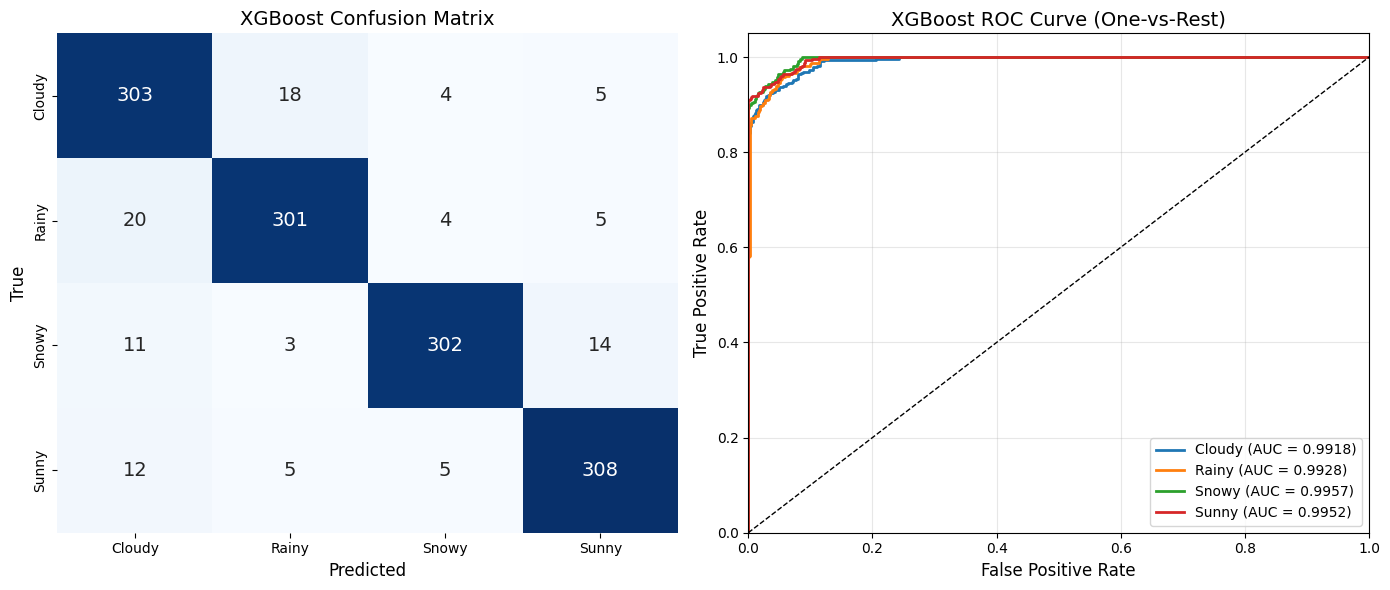

📸 Saved combined plot for svm: D:\ML\Weather-type-prediction-on-tabular-dataset\Images\reports\figures\svm_test_combined.png


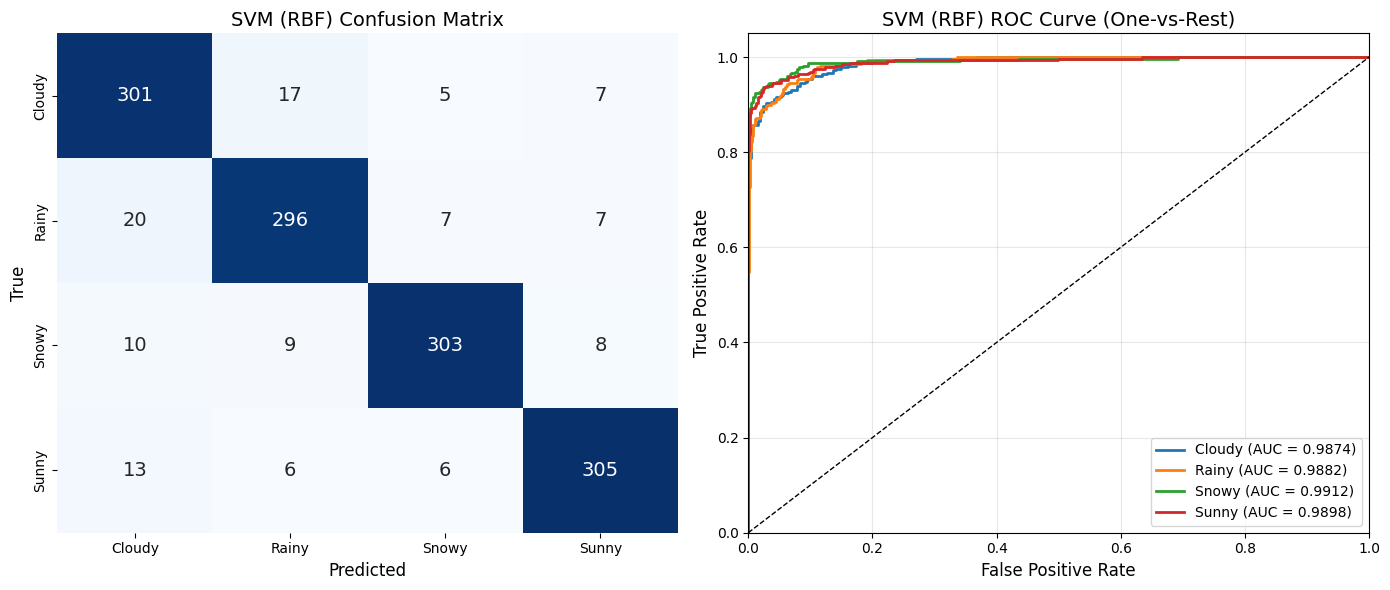

📸 Saved combined plot for logreg: D:\ML\Weather-type-prediction-on-tabular-dataset\Images\reports\figures\logreg_test_combined.png


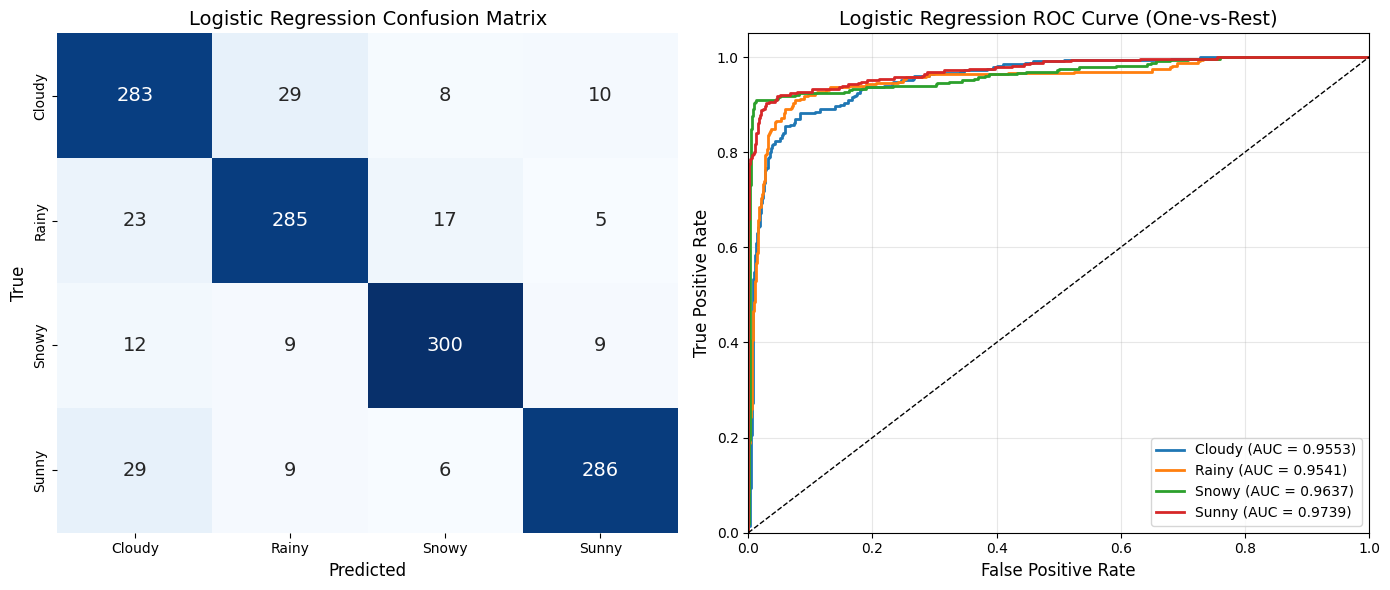

In [15]:
# -----------------------------------------------------------------------------
# 9.4. Chạy vòng lặp vẽ hình cho từng mô hình
# -----------------------------------------------------------------------------
print("\n--- Tạo hình ảnh báo cáo (Figures 7, 8, 9) ---")
for mk, pipe in fitted.items():
    plot_composite_evaluation(
        model_key=mk, 
        model_pipe=pipe, 
        X_test=X_test, 
        y_test_enc=y_test_enc, 
        classes=list(le.classes_), 
        out_dir=OUT_FIG,
        model_map=model_map
    )

## 9.5. Phân tích chi tiết kết quả định lượng và trực quan

Dựa trên biểu đồ Ma trận nhầm lẫn (Confusion Matrix) và Đường cong ROC (Receiver Operating Characteristic) thu được từ tập kiểm tra (Test set), hiệu năng của ba mô hình được phân tích chi tiết như sau:

### 1. Logistic Regression (L2, Multinomial)
*Quan sát Hình 7 (Logistic Regression)*

*   **Ma trận nhầm lẫn:** Mô hình gặp khó khăn lớn nhất trong việc phân biệt giữa hai nhãn **Cloudy** và **Rainy**. Cụ thể, có **29** mẫu thực tế là *Cloudy* bị dự đoán nhầm thành *Rainy*, và **23** mẫu *Rainy* bị nhầm thành *Cloudy*. Điều này cho thấy ranh giới quyết định tuyến tính không đủ linh hoạt để tách biệt hai lớp có đặc trưng khí tượng tương đồng (độ ẩm cao, thiếu nắng).
*   **ROC Curve:** Mặc dù diện tích dưới đường cong (AUC) đều trên 0.95, nhưng đường cong của lớp *Cloudy* (0.9553) và *Rainy* (0.9541) thấp hơn rõ rệt so với *Sunny* (0.9739) và *Snowy* (0.9637). Điều này củng cố nhận định rằng mô hình tuyến tính hoạt động kém hiệu quả hơn ở các vùng dữ liệu giao thoa.

### 2. Support Vector Machine (Kernel RBF)
*Quan sát Hình 8 (SVM)*

*   **Ma trận nhầm lẫn:** Việc sử dụng Kernel RBF (phi tuyến) đã cải thiện đáng kể khả năng phân tách. Số lượng mẫu *Cloudy* được dự đoán đúng tăng từ **283** (LogReg) lên **301**, và *Rainy* từ **285** lên **296**. Sự nhầm lẫn giữa *Cloudy* và *Rainy* giảm đi đáng kể (từ tổng cộng 52 ca nhầm lẫn xuống còn 37).
*   **ROC Curve:** Các đường cong ROC tiệm cận góc trên bên trái hơn, với AUC trung bình đạt xấp xỉ **0.99**. Khoảng cách hiệu năng giữa các lớp được thu hẹp, cho thấy SVM xử lý tốt hơn các mối quan hệ phi tuyến trong dữ liệu.

### 3. XGBoost (Ensemble)
*Quan sát Hình 9 (XGBoost)*

*   **Ma trận nhầm lẫn:** XGBoost thể hiện hiệu năng vượt trội nhất. Số lượng dự đoán đúng trên nhãn khó nhất (*Cloudy*) đạt **303** mẫu. Đặc biệt, nhãn *Sunny* đạt độ chính xác rất cao với **308** mẫu đúng (cao nhất trong cả 3 mô hình). Các ô nằm ngoài đường chéo chính (sai số) có giá trị rất nhỏ và phân bố thưa thớt.
*   **ROC Curve:** Đường cong ROC gần như vuông góc, với AUC của tất cả các lớp đều vượt ngưỡng **0.99** (đặc biệt *Snowy* và *Sunny* đạt > 0.995). Kết quả này khẳng định mô hình cây quyết định tăng cường (Gradient Boosting) khai thác rất tốt các ngưỡng quyết định (decision thresholds) phức tạp của các biến như *Humidity* hay *Cloud Cover*.

### ➤ Tổng kết so sánh
| Tiêu chí | Logistic Regression | SVM (RBF) | XGBoost |
| :--- | :--- | :--- | :--- |
| **Khả năng phân loại Cloudy/Rainy** | Thấp (Nhiều nhầm lẫn) | Tốt (Cải thiện rõ rệt) | **Xuất sắc** |
| **Độ nhạy (Recall) trung bình** | ~87% | ~91% | **~92%** |
| **Đặc điểm đường biên quyết định** | Tuyến tính (Cứng nhắc) | Phi tuyến (Linh hoạt) | **Phi tuyến & Phân cấp (Tối ưu)** |

**Kết luận:** **XGBoost** là mô hình phù hợp nhất cho bài toán này nhờ khả năng xử lý tốt các đặc trưng giao thoa và đạt độ ổn định cao trên mọi nhãn dự báo.